# Churn Prediction in the Credit Card Industry
![Churn Prediction](Images/Churn.jpg)
## Objective:
<p align="justify">
Early detection of customers at risk of churning the credit card service. A structured approach is adopted to develop data understanding, preparation, algorithm selection, modelling, and evaluation. All the steps are presented. Models are extensively evaluated using accuracy, precision, sensitivity, specificity and confusion matrices.
</p>


[Churns.csv](https://github.com/justgrossi/Portfolio/blob/main/2.Churn_Prediction/churns.csv)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Data exploration
def load_and_inspect_data(file_path):
    """Load the dataset and perform initial inspection"""
    print("=" * 60)
    print("LOADING AND INSPECTING DATA")
    print("=" * 60)
    
    # Load the data
    df = pd.read_csv(file_path)
    
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumn names and types:")
    print(df.dtypes)
    
    print(f"\nMissing values per column:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    print(f"\nDuplicated values:")
    print(df.duplicated().sum())
    display(df.head())
    return df


def check_values(cols):
    for col in cols:
        print(f'VARIABLE: {col}')
        print(df[col].value_counts())
        print('================')

In [3]:
file_path='churns.csv'
df=load_and_inspect_data(file_path)

LOADING AND INSPECTING DATA
Dataset shape: (10127, 20)

Column names and types:
churned            object
age                 int64
gender             object
numDep              int64
eduLevel           object
marital            object
incomeCat          object
cardCat            object
monthsOnBook        int64
totBought           int64
monthsInactive      int64
numContacts         int64
credLim           float64
revBal              int64
credBought        float64
delta12amt        float64
totTransAmt         int64
totTransCount       int64
delta12count      float64
ratio             float64
dtype: object

Missing values per column:
Series([], dtype: int64)

Duplicated values:
0


,churned,age,gender,numDep,eduLevel,marital,incomeCat,cardCat,monthsOnBook,totBought,monthsInactive,numContacts,credLim,revBal,credBought,delta12amt,totTransAmt,totTransCount,delta12count,ratio
0,no,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,no,49,F,5,Graduate,Single,Less than $40K,blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,no,51,M,3,Graduate,Married,$80K - $120K,blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,no,40,F,4,High School,Unknown,Less than $40K,blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,no,40,M,3,Uneducated,Married,$60K - $80K,blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
cols=['gender', 'eduLevel', 'marital', 'incomeCat', 'cardCat']
check_values(cols)

VARIABLE: gender
gender
F    5358
M    4769
Name: count, dtype: int64
VARIABLE: eduLevel
eduLevel
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64
VARIABLE: marital
marital
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64
VARIABLE: incomeCat
incomeCat
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64
VARIABLE: cardCat
cardCat
Blue        9421
Silver       538
Gold          98
gold          18
silver        17
Platinum      16
blue          15
platinum       4
Name: count, dtype: int64


In [5]:
card_mapper={
    'Blue':'Blue',
    'blue':'Blue',
    'Silver' : 'Silver',
    'Gold':'Gold',
    'gold':'Gold',
    'silver' : 'Silver',
    'Platinum' : 'Platinum',
     'platinum' : 'Platinum' 
}

df['cardCat']=df['cardCat'].map(card_mapper)

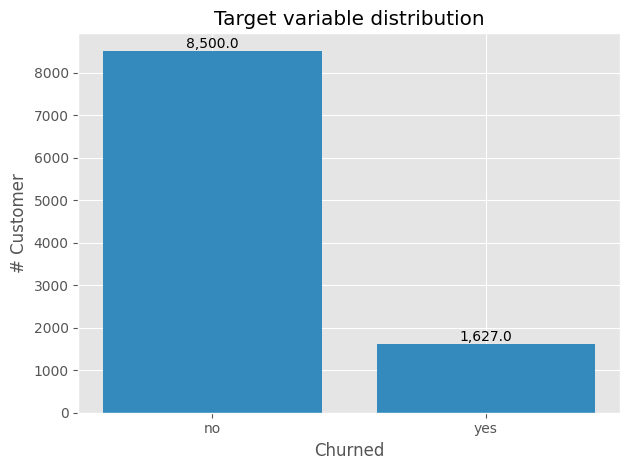

In [6]:
# Label distribution

plt.style.use('ggplot')

x=df['churned'].value_counts().index
y=df['churned'].value_counts().values

plt.bar(x, y)
bars = plt.bar(x, y)
plt.bar_label(bars, fmt='{:,}')
plt.title('Target variable distribution')
plt.xticks([0, 1])
plt.xlabel('Churned')
plt.ylabel('# Customer')

plt.tight_layout()
plt.show()

In [8]:
# Split into train test

X=df.drop(columns=['churned'])
y=df['churned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# Set function to One-Hot encode X_train

def encoding(df, cols):
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(df[cols])
    encoded_cols = encoder.get_feature_names_out(df[cols].columns)
    encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
    print("\nOne-Hot Encoded DataFrame:")
    print(encoded_df)
    return encoded_df

In [10]:
# One-hot encoding X_train

encoded_df=encoding(X_train, cols)
X_train.drop(columns=cols, inplace=True)
X_train = pd.concat([X_train, encoded_df], axis=1)
X_train = X_train.fillna(0)


One-Hot Encoded DataFrame:
      gender_F  gender_M  eduLevel_College  eduLevel_Doctorate  \
2856       1.0       0.0               0.0                 0.0   
6515       0.0       1.0               0.0                 0.0   
7141       0.0       1.0               0.0                 0.0   
632        1.0       0.0               0.0                 0.0   
3496       0.0       1.0               0.0                 0.0   
...        ...       ...               ...                 ...   
6147       1.0       0.0               0.0                 0.0   
8858       1.0       0.0               0.0                 0.0   
3284       1.0       0.0               0.0                 0.0   
7551       1.0       0.0               0.0                 0.0   
7469       1.0       0.0               0.0                 0.0   

      eduLevel_Graduate  eduLevel_High School  eduLevel_Post-Graduate  \
2856                0.0                   0.0                     0.0   
6515                0.0          

In [11]:
# One-hot encoding X_test

encoded_df=encoding(X_test, cols)
X_test.drop(columns=cols, inplace=True)
X_test = pd.concat([X_test, encoded_df], axis=1)
X_test = X_test.fillna(0)


One-Hot Encoded DataFrame:
      gender_F  gender_M  eduLevel_College  eduLevel_Doctorate  \
2919       0.0       1.0               0.0                 0.0   
9301       1.0       0.0               0.0                 0.0   
2936       1.0       0.0               1.0                 0.0   
8134       1.0       0.0               0.0                 0.0   
5902       1.0       0.0               0.0                 0.0   
...        ...       ...               ...                 ...   
5520       1.0       0.0               0.0                 0.0   
3425       1.0       0.0               0.0                 0.0   
9017       0.0       1.0               0.0                 0.0   
5839       0.0       1.0               0.0                 0.0   
281        0.0       1.0               0.0                 0.0   

      eduLevel_Graduate  eduLevel_High School  eduLevel_Post-Graduate  \
2919                0.0                   0.0                     0.0   
9301                1.0          

In [12]:
# Apply SMOTE on training set to resolve class imbalance

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", Counter(y_train_res))

Resampled class distribution: Counter({'no': 6799, 'yes': 6799})


In [13]:
# Define Models + Parameter Grids

models_param_grid = {
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 3, 5],
            "min_samples_split": [2, 5, 10]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [2, 3, 5]
        }
    )
}

In [14]:
# Cross-validation setup

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}


🔹 Running GridSearchCV for Decision Tree...
✅ Best Params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
✅ CV Accuracy: 0.9572735975596564
✅ Test Accuracy: 0.9259624876604146

🔹 Running GridSearchCV for Gradient Boosting...
✅ Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
✅ CV Accuracy: 0.9844828061787421
✅ Test Accuracy: 0.9649555774925962

📊 Final Comparison:
                   CV Accuracy  Test Accuracy
Decision Tree         0.957274       0.925962
Gradient Boosting     0.984483       0.964956


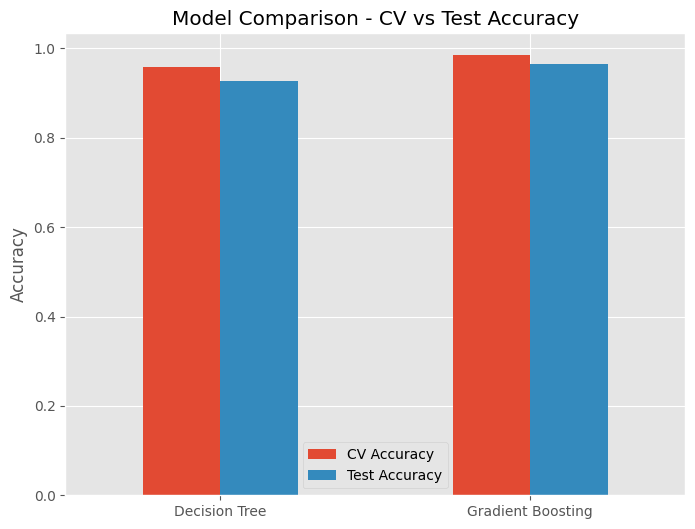

In [15]:
# Train + Tune Each Model

for model_name, (model, param_grid) in models_param_grid.items():
    print(f"\n🔹 Running GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train_res, y_train_res)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Save results
    results[model_name] = {
        "Best Params": grid_search.best_params_,
        "CV Accuracy": grid_search.best_score_,
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True)
    }
    
    print("✅ Best Params:", grid_search.best_params_)
    print("✅ CV Accuracy:", grid_search.best_score_)
    print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))


# 6. Compare Results

print("\n📊 Final Comparison:")
comparison_df = pd.DataFrame({
    model: {
        "CV Accuracy": res["CV Accuracy"],
        "Test Accuracy": res["Test Accuracy"]
    } for model, res in results.items()
}).T

print(comparison_df)



# 7. Plot Comparison

plt.style.use('ggplot')
comparison_df.plot(kind="bar", figsize=(8,6))
plt.title("Model Comparison - CV vs Test Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.8667483089487229


><p style='text-align: justify;'>
Best Parameters are found via GridSearchCV for each model.

> Cross-validation accuracy id computed for model robustness.

> Test accuracy on unseen data.

> Confusion matrices + classification reports.

> Bar chart comparison of CV vs. Test performance

    
</p>